<a href="https://colab.research.google.com/github/aruaru0/bert-regression-test/blob/main/HuggingFace_BERT_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transformerのインストールなど

In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install git+https://github.com/huggingface/accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-toy70mmg
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip

In [2]:
!pip install fugashi
!pip install ipadic
!pip install unidic-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556703 sha256=2a47ba5aeaa3c52e86ba1c4392dc57dbbc50c88b062dc12ab5153ef85b67f99d
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658816 sha256=8e63335b01e2f33d2c60199b0d736515b6a5575449516acf4af0e5e826d39d23
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


# データセットを準備

In [64]:
from datasets import load_dataset

dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese")

In [65]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
})

# Tokenizerの取得

In [74]:
from transformers import AutoTokenizer

model_ckpt = "cl-tohoku/bert-large-japanese"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# データサイズを減らす

In [75]:
SEED = 42
TRAIN_SIZE = 2000
TEST_SIZE = 1000

dataset["train"] = dataset["train"].shuffle(seed=SEED).select(range(TRAIN_SIZE))
dataset["validation"] = dataset["validation"].shuffle(seed=SEED).select(range(TEST_SIZE))
dataset["test"] = dataset["test"].shuffle(seed=SEED).select(range(TEST_SIZE))

# データセットの加工

In [76]:
import torch

MAX = 512

def tokenize(batch):
    enc =  tokenizer(batch["text"], padding=True, truncation=True, max_length=MAX)
    return enc

In [77]:
dataset_encoded = dataset.map(tokenize)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [78]:
small_train_dataset = dataset_encoded['train']
small_valid_dataset = dataset_encoded['validation']
small_test_dataset = dataset_encoded['test']

In [79]:
from datasets import Value
new_features = small_train_dataset.features.copy()
new_features['label'] = Value("float64")
small_train_dataset = small_train_dataset.cast(new_features)
small_valid_dataset = small_valid_dataset.cast(new_features)
small_test_dataset = small_test_dataset.cast(new_features)


Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

# 学習

In [80]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 1

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

In [81]:
from sklearn.metrics import accuracy_score, f1_score
import evaluate
import numpy as np
metric = evaluate.load("mse")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return metric.compute(predictions=predictions, references=labels)

In [82]:
from transformers import TrainingArguments

batch_size = 4
logging_steps = len(small_train_dataset) // batch_size
model_name = "multilingual-sentiments-regression-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [83]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_train_dataset,
    eval_dataset=small_valid_dataset,
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,Mse
1,0.334200,0.220545,0.220545
2,0.164200,0.235635,0.235635
3,0.075900,0.175463,0.175463


TrainOutput(global_step=1500, training_loss=0.19143313598632813, metrics={'train_runtime': 829.3681, 'train_samples_per_second': 7.234, 'train_steps_per_second': 1.809, 'total_flos': 1319544825569064.0, 'train_loss': 0.19143313598632813, 'epoch': 3.0})

# テストデータに対する結果を評価


In [84]:
preds_output = trainer.predict(small_test_dataset)

In [86]:
x = [[] for _ in range(3)]
cnt = 0
for p, l in zip(preds_output.predictions, preds_output.label_ids) :
  x[int(l)].append(p[0]+1)
  if cnt == 100 : break
  cnt += 1

for i in range(3):
  v = np.array(x[i])
  print(f"{i+1}: mean={v.mean()}, std = {v.std()}")

1: mean=1.2513489521566954, std = 0.40052614396856157
2: mean=1.960308731082947, std = 0.39427579577548655
3: mean=2.77929927110672, std = 0.34950135155470685


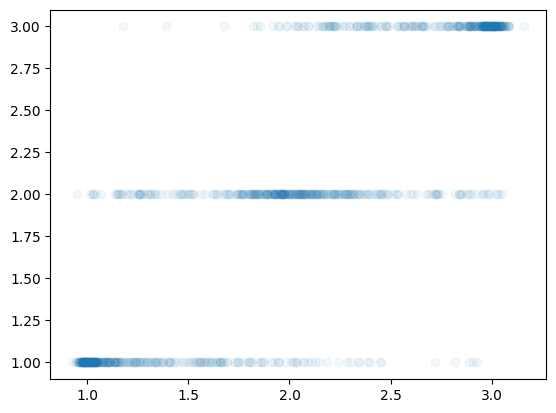

In [87]:
import matplotlib.pyplot as plt

plt.scatter(preds_output.predictions+1, preds_output.label_ids+1, alpha=0.05)

{'whiskers': [<matplotlib.lines.Line2D at 0x7dc6cf5df100>,
 'caps': [<matplotlib.lines.Line2D at 0x7dc6cf5df640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7dc6cf5deec0>,
 'medians': [<matplotlib.lines.Line2D at 0x7dc6cf5dfb80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7dc6cf5dfe20>,
 'means': []}

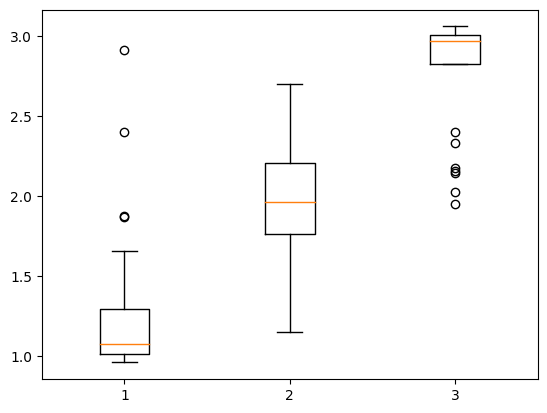

In [88]:
plt.boxplot(x)

# モデルの保存、読み込み

In [89]:
trainer.save_model(f"./{model_name}-test")

In [90]:
tokenizer = AutoTokenizer\
    .from_pretrained(f"./{model_name}-test")

model = (AutoModelForSequenceClassification
    .from_pretrained(f"./{model_name}-test")
    .to(device))